In [3]:
import numpy as np
import json
from scipy.sparse import load_npz,save_npz,diags,csr_matrix
import scipy.sparse as sp
import pandas as pd
import os
from io import BytesIO
from tqdm import tqdm
import RWR
from scipy.sparse.linalg import eigsh
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from pathlib import Path
import igraph as ig
import leidenalg as la
from matplotlib.backends.backend_pdf import PdfPages
from pypdf import PdfReader, PdfWriter
from tempfile import NamedTemporaryFile
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import community as community_louvain
import pickle
from collections import defaultdict

In [4]:
# Load all the matrices needed
DISEASE = "BIPOLAR"
OUTPUT_DIRECTORY = f"../output/{DISEASE}/"
DGIDB_DIRECTORY = f"../../Gen_Hypergraph/output/DGIDB_{DISEASE}/"
MSIGDB_DIRECTORY = "../../Gen_Hypergraph/output/MSigDB_Full/"

## DGIDB
DGIDB_binary_matrix = load_npz(DGIDB_DIRECTORY + "hypergraph_incidence_matrix_binary.npz")
DGIDB_weighted_matrix = load_npz(DGIDB_DIRECTORY + "hypergraph_incidence_matrix_weighted.npz")
DGIDB_gene_weight_diag_matrix = load_npz(DGIDB_DIRECTORY + "gene_weight_diag_matrix.npz")
DGIDB_diag_node_degree_matrix = load_npz(DGIDB_DIRECTORY + "diag_node_degree_matrix.npz")
DGIDB_inverse_diag_edge_degree_matrix = load_npz(
    DGIDB_DIRECTORY + "inverse_diag_edge_degree_matrix.npz"
    )

## MSIGDB
MSIGDB_binary_matrix = load_npz(MSIGDB_DIRECTORY + "hypergraph_incidence_matrix_binary.npz")
MSIGDB_weighted_matrix = load_npz(MSIGDB_DIRECTORY + "hypergraph_incidence_matrix_weighted.npz")
MSIGDB_gene_weight_diag_matrix = load_npz(MSIGDB_DIRECTORY + "gene_weight_diag_matrix.npz")
MSIGDB_diag_node_degree_matrix = load_npz(MSIGDB_DIRECTORY + "diag_node_degree_matrix.npz")
MSIGDB_inverse_diag_edge_degree_matrix = load_npz(
    MSIGDB_DIRECTORY + "inverse_diag_edge_degree_matrix.npz"
    )

In [5]:
# queue = [[i] for i in range(1,25)]
# resolution = 1.0
# for T in queue:
#     path = f"../output/{DISEASE}/diffusion_dist_matrices/ddm_{T}_res-{resolution}.npy"
#     arr = np.load(path)
#     arr = arr.astype(np.float32)
#     np.save(path, arr)
#     print(f"Overwritten (float32): {path}")

In [6]:
# Useful Functions
def is_symmetric(W,tol = 1e-8):
    diff = (W - W.T)
    check = np.all(np.abs(diff.data) < tol)
    return check

def degree_array(W, a=1):
    return np.asarray(W.sum(axis=a)).ravel()

def degree_diagonal_matrix(W, a=1):
    d = degree_array(W,a)
    return sp.diags(d, offsets=0, format='csr')

def symmetrically_normalize(W, a=1):
    D = np.asarray(W.sum(axis=a)).ravel()
    D_inv_sqrt = np.zeros_like(D)
    nze = D != 0
    D_inv_sqrt[nze] = 1 / np.sqrt(D[nze])

    W_sym = W.multiply(D_inv_sqrt)              # scale columns
    W_sym = W_sym.multiply(D_inv_sqrt[:, None]) # scale rows    
    return W_sym.tocsr()

In [7]:
#1 Compute diffusion profile of each gene after t steps of multilayer random walk with restart 


## DGIDB
H,W_v,D_v,D_e_inv = DGIDB_weighted_matrix, DGIDB_gene_weight_diag_matrix, DGIDB_diag_node_degree_matrix, DGIDB_inverse_diag_edge_degree_matrix

# Construct D_v^(-1/2)
d = (D_v @ W_v).diagonal()
d_inv_sqrt = np.zeros_like(d)
nonzero_mask = d > 0
d_inv_sqrt[nonzero_mask] = 1.0 / np.sqrt(d[nonzero_mask])
D_v_sqrt_inv = diags(d_inv_sqrt)

DGIDB_adjacency_matrix = D_v_sqrt_inv @ H @ D_e_inv @ H.T @ D_v_sqrt_inv


## MSIGDB
H,W_v,D_v,D_e_inv = MSIGDB_weighted_matrix, MSIGDB_gene_weight_diag_matrix, MSIGDB_diag_node_degree_matrix, MSIGDB_inverse_diag_edge_degree_matrix

# Construct D_v^(-1/2)
d = (D_v @ W_v).diagonal()
d_inv_sqrt = np.zeros_like(d)
nonzero_mask = d > 0
d_inv_sqrt[nonzero_mask] = 1.0 / np.sqrt(d[nonzero_mask])
D_v_sqrt_inv = diags(d_inv_sqrt)

MSIGDB_adjacency_matrix = D_v_sqrt_inv @ H @ D_e_inv @ H.T @ D_v_sqrt_inv

# Compute Degree Diagonal Matrices
DGIDB_rows_sums = degree_array(DGIDB_adjacency_matrix)
MSIGDB_rows_sums = degree_array(MSIGDB_adjacency_matrix)

In [8]:
print(is_symmetric(DGIDB_adjacency_matrix))
print(is_symmetric(MSIGDB_adjacency_matrix))

True
True


In [9]:
# Symmetric Normalization
DGIDB_adjacency_matrix = symmetrically_normalize(DGIDB_adjacency_matrix)
MSIGDB_adjacency_matrix = symmetrically_normalize(MSIGDB_adjacency_matrix)

In [10]:
print(is_symmetric(DGIDB_adjacency_matrix))
print(is_symmetric(MSIGDB_adjacency_matrix))

True
True


In [11]:
# density = DGIDB_adjacency_matrix.nnz / (DGIDB_adjacency_matrix.shape[0] * DGIDB_adjacency_matrix.shape[1])
# print("DGIDB Density:", density)
# density = MSIGDB_adjacency_matrix.nnz / (MSIGDB_adjacency_matrix.shape[0] * MSIGDB_adjacency_matrix.shape[1])
# print("MSIGDB Density:", density)

In [12]:
# Check nonzero average
DGIDB_nonzero_average = DGIDB_adjacency_matrix[DGIDB_adjacency_matrix != 0].mean()
MSIGDB_nonzero_average = MSIGDB_adjacency_matrix[MSIGDB_adjacency_matrix != 0].mean()

print("DGIDB nonzero average:",DGIDB_nonzero_average,"\nMSIGDB nonzero average:",MSIGDB_nonzero_average)

DGIDB nonzero average: 0.009289970824902828 
MSIGDB nonzero average: 9.87564623806718e-05


In [13]:
# # Density normalization version 1
# target_average = MSIGDB_nonzero_average
# DGIDB_adjacency_matrix = (target_average / DGIDB_nonzero_average) * DGIDB_adjacency_matrix
# MSIGDB_adjacency_matrix = (target_average / MSIGDB_nonzero_average) * MSIGDB_adjacency_matrix

# DGIDB_nonzero_average = DGIDB_adjacency_matrix[DGIDB_adjacency_matrix != 0].mean()
# MSIGDB_nonzero_average = MSIGDB_adjacency_matrix[MSIGDB_adjacency_matrix != 0].mean()

# print(DGIDB_nonzero_average,MSIGDB_nonzero_average)

In [14]:
# Density normalization version 2
DGIDB_mean_degree = DGIDB_rows_sums[DGIDB_rows_sums != 0].mean()
MSIGDB_mean_degree = MSIGDB_rows_sums[MSIGDB_rows_sums != 0].mean()
print(DGIDB_mean_degree,MSIGDB_mean_degree)
# print(DGIDB_rows_sums,MSIGDB_rows_sums)

DGIDB_weight = (1/DGIDB_mean_degree) / ((1/DGIDB_mean_degree)+(1/MSIGDB_mean_degree))
MSIGDB_weight = (1/MSIGDB_mean_degree) / ((1/DGIDB_mean_degree)+(1/MSIGDB_mean_degree))
geo_mean_weight = (DGIDB_weight * MSIGDB_weight)**(1/2)
print(DGIDB_weight,MSIGDB_weight)
print(geo_mean_weight)

0.5022932647447539 0.2379564756116163
0.3214543182373284 0.6785456817626716
0.46703473053286176


In [15]:
## Build interlayer coupling matrices between the two layers

# Open the JSON file and load its content into a dictionary
with open(DGIDB_DIRECTORY + "gene_to_index.json", "r") as file:
    dgidb = json.load(file)
with open(MSIGDB_DIRECTORY + "gene_to_index.json", "r") as file:
    msigdb = json.load(file)
    
# Jump probability for matching genes
w = 1

# Number of genes (assuming they are both of same size or matchable)
num_genes_dgidb = len(dgidb)
num_genes_msigdb = len(msigdb)

# Initialize the inter-layer matrix with zeros
interlayer_transition_matrix = np.zeros((num_genes_msigdb,num_genes_dgidb))
i = 0
# Build the inter-layer matrix
for gene_dgidb, idx_dgidb in dgidb.items():
    # If the gene exists in both gene-to-index mappings
    if gene_dgidb in msigdb:      
        idx_msigdb = msigdb[gene_dgidb]
        interlayer_transition_matrix[idx_msigdb,idx_dgidb] = w  # Set jump probability
        i += 1
    else:
        print(f"Gene {gene_dgidb} not found in MSIGDB mapping.")
rows_with_high_sum = np.where(interlayer_transition_matrix.sum(axis=1) > 0)[0]
print(i/len(dgidb), "of DGIDB genes have a match in MSIGDB")

Gene 927 not found in MSIGDB mapping.
Gene 11 not found in MSIGDB mapping.
Gene 724 not found in MSIGDB mapping.
Gene 360158 not found in MSIGDB mapping.
Gene 469 not found in MSIGDB mapping.
Gene 100529264 not found in MSIGDB mapping.
Gene 2609 not found in MSIGDB mapping.
Gene 447 not found in MSIGDB mapping.
Gene 453 not found in MSIGDB mapping.
Gene 459 not found in MSIGDB mapping.
Gene 2616 not found in MSIGDB mapping.
Gene 442 not found in MSIGDB mapping.
Gene 600 not found in MSIGDB mapping.
Gene 507 not found in MSIGDB mapping.
Gene 62 not found in MSIGDB mapping.
Gene 68 not found in MSIGDB mapping.
Gene 2772 not found in MSIGDB mapping.
Gene 485 not found in MSIGDB mapping.
Gene 620 not found in MSIGDB mapping.
Gene 121131 not found in MSIGDB mapping.
Gene 285834 not found in MSIGDB mapping.
Gene 6962 not found in MSIGDB mapping.
Gene 1480 not found in MSIGDB mapping.
Gene 2749 not found in MSIGDB mapping.
Gene 1624 not found in MSIGDB mapping.
Gene 63 not found in MSIGDB map

In [16]:
# # Row-Normalization
# # DGIDB
# row_sums = np.array(DGIDB_adjacency_matrix.sum(axis=1)).ravel()
# # inverse row sums (avoid division by zero)
# inv_row_sums = np.reciprocal(row_sums, where=row_sums!=0)
# # build diagonal matrix of inverses
# D_inv = sp.diags(inv_row_sums)
# DGIDB_adjacency_matrix = D_inv @ DGIDB_adjacency_matrix

# # MSIGDB
# row_sums = np.array(MSIGDB_adjacency_matrix.sum(axis=1)).ravel()
# # inverse row sums (avoid division by zero)
# inv_row_sums = np.reciprocal(row_sums, where=row_sums!=0)
# # build diagonal matrix of inverses
# D_inv = sp.diags(inv_row_sums)
# MSIGDB_adjacency_matrix = D_inv @ MSIGDB_adjacency_matrix

# # Coupling Matrix
# row_sums = interlayer_transition_matrix.sum(axis = 1, keepdims= True)
# row_sums[row_sums == 0] = 1 
# interlayer_transition_matrix = interlayer_transition_matrix / row_sums

In [17]:
# # Check for Row-stochastic
# row_sums = np.array(DGIDB_adjacency_matrix.sum(axis=1)).ravel()
# print(row_sums)
# ok = np.all(np.isclose(row_sums, 1.0)|np.isclose(row_sums, 0))
# print("Every row sums to 0 or 1?", ok)

# row_sums = np.array(MSIGDB_adjacency_matrix.sum(axis=1)).ravel()
# print(row_sums)
# ok = np.all(np.isclose(row_sums, 1.0)|np.isclose(row_sums, 0))
# print("Every row sums to 0 or 1?", ok)

In [18]:
## Build the multilayer transition matrix
# interlayer_transition_prob = target_average
interlayer_transition_prob = 0.1

A = (1-interlayer_transition_prob) * DGIDB_weight * DGIDB_adjacency_matrix
B = interlayer_transition_prob * geo_mean_weight * interlayer_transition_matrix.T
C = interlayer_transition_prob * geo_mean_weight * interlayer_transition_matrix
D =(1-interlayer_transition_prob) * MSIGDB_weight * MSIGDB_adjacency_matrix

multilayer_transition_matrix = sp.bmat([
    [A, B],
    [C, D]
]).tocsr()

num_genes = multilayer_transition_matrix.shape[0]

In [19]:
density = multilayer_transition_matrix.nnz / (multilayer_transition_matrix.shape[0] * multilayer_transition_matrix.shape[1])
print("MTM Density:", density)

MTM Density: 0.14986548517575804


In [20]:
MTM_average = multilayer_transition_matrix[multilayer_transition_matrix != 0].mean()
print("MTM nonzero average:",MTM_average)

MTM nonzero average: 6.500572751143779e-05


In [21]:
# ## Row-normalize the multilayer transition matrix
# row_sums = np.array(multilayer_transition_matrix.sum(axis=1)).ravel()
# nonzero_rows = row_sums != 0
# inv_row_sums = np.zeros_like(row_sums)
# inv_row_sums[nonzero_rows] = 1.0 / row_sums[nonzero_rows]
# multilayer_transition_matrix = diags(inv_row_sums) @ multilayer_transition_matrix

In [22]:
row_sums = np.array(multilayer_transition_matrix.sum(axis=1)).ravel()
print(row_sums)
ok = np.all(np.isclose(row_sums, 1.0)|np.isclose(row_sums, 0))
print("Every row sums to 0 or 1?", ok)

[0.46743252 0.48778527 0.04670347 ... 0.0583269  0.05098928 0.03964587]
Every row sums to 0 or 1? False


In [23]:
# Compute top k eigenvalues by magnitude
def top_k_eigenvalues(M,k):
    vals, vecs = eigsh(M, k=k, which='LM')  # 'LM' = Largest Magnitude
    idx = np.argsort(np.abs(vals))[::-1]
    vals, vecs = vals[idx], vecs[:, idx]
    return vals, vecs

In [24]:
# Build diffusion matrix from eigenvalues and eigenvectors (double check)
def build_diffusion_dist_matrix(vals,vecs,t):
    X_t = vecs * (vals ** (t))
    D_t2 = squareform(pdist(X_t, metric='sqeuclidean'))
    return D_t2

# Build kNN
def build_kNN(diffusion_dist_matrix,k):
    # Choose sigma to be the median of pair-wise distance
    tmp = diffusion_dist_matrix.astype(np.float32, copy=True)
    np.sqrt(tmp, out=tmp)
    sigma = np.median(tmp, overwrite_input=True)

    n = diffusion_dist_matrix.shape[0]

    # Used to indicate position of nonzero value needed to record (constructing a sparse matrix for efficiency)
    rows, cols, vals = [], [], []
    for i in range(n):
        profile = np.exp(-diffusion_dist_matrix[i] / (2* (sigma**2))) 
        idx = np.argpartition(-profile, k+1)[:k+1]  # top-k+1 (includes self)
        idx = idx[idx != i]                      # drop self
        rows += [i]*k
        cols += list(idx[:k])
        vals += list(profile[idx[:k]])
    adj_mat = csr_matrix((vals, (rows, cols)), shape=(n, n))
    kNN_graph = nx.from_numpy_array(adj_mat)
    return adj_mat,kNN_graph

# Louvain clustering


def louvain_from_adj(A, resolution=1.0, random_state=0, keep_lcc=False):
    """
    A: symmetric, non-negative scipy.sparse adjacency (CSR preferred).
    Returns: labels (np.ndarray of length n), graph G (NetworkX), node_order
    """
    # if not sp.isspmatrix(A):  # allow dense but convert
    #     A = sp.csr_matrix(A)
    # # Optional: ensure symmetry numerically
    # if (A - A.T).nnz != 0:
    #     raise ValueError("Adjacency must be symmetric. Symmetrize first.")

    # Build graph
    # networkx >=3.0: from_scipy_sparse_array; older: from_scipy_sparse_matrix
    G = nx.from_scipy_sparse_array(A, edge_attribute='weight')  # undirected by default

    if keep_lcc:
        # keep only the largest connected component if you prefer
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()

    # Run Louvain
    part = community_louvain.best_partition(
        G, weight='weight', resolution=resolution, random_state=random_state
    )
    node_order = sorted(G.nodes())
    labels = np.array([part[i] for i in node_order], dtype=int)
    return labels, G, node_order

def leiden_from_knn_adjacency(
    A,
    *,
    method="modularity",      # "modularity" | "rb" | "cpm"
    resolution=1.0,           # used by "rb" and "cpm"
    n_iterations=-1,          # -1 => until no improvement
    seed=42,
    use_weights=True
):
    """
    Run Leiden on a symmetric, undirected (weighted) kNN adjacency (SciPy sparse).

    Returns
    -------
    labels : np.ndarray[int]
        Community ID per node (0..k-1)
    quality : float
        Objective value (modularity / RB / CPM depending on 'method')
    """
    if not sp.issparse(A):
        raise TypeError("A must be a SciPy sparse matrix.")
    # Normalize format & dtype
    A = A.tocsr().astype(np.float32, copy=False)

    # Clean diagonal and robustly symmetrize
    A.setdiag(0.0)
    A.eliminate_zeros()
    A = A.maximum(A.T)  # keep max weight per undirected edge

    # Build igraph from upper triangle (each undirected edge once)
    U = sp.triu(A, k=1, format="coo")
    n = A.shape[0]
    g = ig.Graph(n=n, edges=list(zip(U.row.tolist(), U.col.tolist())), directed=False)
    wname = None
    if use_weights:
        g.es["weight"] = U.data.tolist()
        wname = "weight"

    # Pick partition class + kwargs
    m = method.lower()
    if m == "modularity":
        part_cls = la.ModularityVertexPartition
        kwargs = dict(weights=wname)
    elif m == "rb":
        part_cls = la.RBConfigurationVertexPartition
        kwargs = dict(weights=wname, resolution_parameter=resolution)
    elif m == "cpm":
        part_cls = la.CPMVertexPartition
        kwargs = dict(weights=wname, resolution_parameter=resolution)
    else:
        raise ValueError("method must be 'modularity', 'rb', or 'cpm'")

    # Run Leiden
    part = la.find_partition(
        g,
        part_cls,
        n_iterations=n_iterations,
        seed=seed,
        **kwargs
    )

    labels = np.array(part.membership, dtype=np.int32)
    communities = [list(c) for c in part]
    return labels, float(part.quality()), communities

In [25]:
# # Louvain
# def DDBC(MTM,num_eigenvalues,num_neighbors,resolution,T):
#     vals,vecs = top_k_eigenvalues(M = MTM, k = num_eigenvalues)

#     diffusion_dist_matrix = np.empty((num_genes,num_genes))
#     for t in T:
#         np.add(diffusion_dist_matrix, 
#                build_diffusion_dist_matrix(vals,vecs,t,num_eigenvalues), 
#                out=diffusion_dist_matrix)
#     diffusion_dist_matrix = diffusion_dist_matrix / len(T)
    
#     kNN_adjacency_matrix = build_kNN(diffusion_dist_matrix,num_neighbors)

#     # # Symmetrize the matrix by adding edges to one way edges and set weight to average
#     # kNN_adjacency_matrix = (kNN_adjacency_matrix + kNN_adjacency_matrix.T).multiply(0.5).tocsr()

#     # Symmetrize the matrix by unioning
#     kNN_adjacency_matrix = kNN_adjacency_matrix.maximum(kNN_adjacency_matrix.T)

#     return louvain_from_adj(kNN_adjacency_matrix, resolution = resolution, keep_lcc = False) 

In [26]:
# Leiden
def DDBC(vals,
         vecs,
         num_neighbors,
         resolution,
         T,
         leiden_method = "modularity",
         ddm = None):
    if ddm is None:
        diffusion_dist_matrix = np.empty((num_genes,num_genes))
        for t in T:
            np.add(diffusion_dist_matrix, 
                build_diffusion_dist_matrix(vals,vecs,t), 
                out=diffusion_dist_matrix)
        diffusion_dist_matrix = diffusion_dist_matrix / len(T)
        np.save(f"../output/{DISEASE}/diffusion_dist_matrices/ddm_{T}_res-{resolution}.npy",diffusion_dist_matrix)
    else:
        diffusion_dist_matrix = ddm
    kNN_adjacency_matrix, kNN_graph = build_kNN(diffusion_dist_matrix,num_neighbors)

    # # Symmetrize the matrix by adding edges to one way edges and set weight to average
    # kNN_adjacency_matrix = (kNN_adjacency_matrix + kNN_adjacency_matrix.T).multiply(0.5).tocsr()

    # Symmetrize the matrix by unioning
    kNN_adjacency_matrix = kNN_adjacency_matrix.maximum(kNN_adjacency_matrix.T)
    return (*leiden_from_knn_adjacency(kNN_adjacency_matrix,method=leiden_method,resolution=resolution,n_iterations=-1,seed=42), kNN_graph)

In [27]:
def community_report_onepage(labels, score, out_pdf="leiden_community_report.pdf", *,
                             extra_text=None, bins="auto", title="Community Sizes", time_steps = "N/A"):
    """
    Create ONE PDF page (top: text summary, bottom: histogram).
    If out_pdf exists: append this page. Else: create it.

    Requires: matplotlib, pypdf  (pip install pypdf)
    """
    # ---- inputs ----
    labels = np.asarray(labels)
    if labels.ndim != 1:
        raise ValueError("labels must be a 1-D array of community ids")

    # ---- stats ----
    sizes = np.bincount(labels.astype(np.int64, copy=False))
    sizes_sorted = np.sort(sizes)
    n, k = sizes.sum(), sizes.size

    lines = [
        "Leiden Partition Summary",
        "========================",
        f"Nodes (n):           {n:,}",
        f"Time steps:          {time_steps}",
        f"Communities (k):     {k:,}",
        f"Size (min):          {int(sizes_sorted[0]) if k else 0:,}",
        f"Size (median):       {float(np.median(sizes_sorted)) if k else 0.0:.3f}",
        f"Size (mean):         {float(sizes_sorted.mean()) if k else 0.0:.6f}",
        f"Size (max):          {int(sizes_sorted[-1]) if k else 0:,}",
        f"Score:               {score}",
        "",
        "Top 10 largest communities (id: size):",
    ]
    for cid in np.argsort(-sizes)[:min(10, k)]:
        lines.append(f"  {int(cid):5d}: {int(sizes[cid]):,}")
    if extra_text:
        lines += ["", "Extra:", *([extra_text] if isinstance(extra_text, str) else list(extra_text))]
    summary_text = "\n".join(lines)

    # ---- draw single-page figure ----
    fig = plt.figure(figsize=(8.5, 11), dpi=150)          # US Letter, higher DPI
    ax_text = fig.add_axes([0.06, 0.55, 0.88, 0.40])      # [left, bottom, width, height]
    ax_text.axis("off")
    ax_text.text(0.0, 1.0, summary_text, va="top", ha="left", fontsize=11, family="monospace")

    ax_hist = fig.add_axes([0.10, 0.08, 0.80, 0.38])
    ax_hist.hist(sizes, bins=bins)
    ax_hist.set_xlabel("Community size")
    ax_hist.set_ylabel("Count of communities")
    ax_hist.set_title(f"Distribution of {title}")

    # ---- write this page to a temp PDF on disk ----
    with NamedTemporaryFile(delete=False, suffix=".pdf") as tmpf:
        tmp_page = Path(tmpf.name)
    with PdfPages(tmp_page) as pdf:
        pdf.savefig(fig)
    plt.close(fig)

    # ---- append/create using PdfReader/PdfWriter (robust across versions) ----
    try:
        from pypdf import PdfReader, PdfWriter
    except Exception as e:
        try: os.remove(tmp_page)
        except: pass
        raise RuntimeError("Please install 'pypdf' (e.g., `pip install pypdf`).") from e

    out_pdf = Path(out_pdf)
    tmp_out = out_pdf.with_suffix(out_pdf.suffix + ".tmp")

    writer = PdfWriter()

    # if existing, copy old pages first
    if out_pdf.exists():
        with open(out_pdf, "rb") as f_exist:
            reader = PdfReader(f_exist)
            for p in reader.pages:
                writer.add_page(p)

    # add the new single page
    with open(tmp_page, "rb") as f_new:
        reader_new = PdfReader(f_new)
        for p in reader_new.pages:
            writer.add_page(p)

    # atomic write
    with open(tmp_out, "wb") as f_out:
        writer.write(f_out)
    os.replace(tmp_out, out_pdf)

    # cleanup
    try: os.remove(tmp_page)
    except: pass

    return out_pdf


In [28]:
# Leiden Clustering
pdf_path = f"../output/{DISEASE}/leiden_report.pdf"
num_eigenvalues = 100
num_neighbors = 50
method = "modularity"
resolution = 1.0
num_bins = 100
write = True
queue = [[i] for i in range(1,25)]
label_list = []
score_list = []
graph_list = []
communities_list = []

In [29]:
# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = top_k_eigenvalues(multilayer_transition_matrix,num_eigenvalues)
print("Eigenvalues:", eigenvalues)
print("Eigenvectors shape:", eigenvectors.shape)

Eigenvalues: [0.61242336 0.59866498 0.54179748 0.53904938 0.53075806 0.51811882
 0.49859393 0.45237414 0.41483484 0.38309682 0.38072611 0.35675655
 0.33747566 0.3149082  0.29515302 0.28917883 0.27862162 0.27051642
 0.26738069 0.26492934 0.26488598 0.26116244 0.2539614  0.25242474
 0.25074152 0.2493121  0.24786552 0.24626212 0.24520576 0.24180322
 0.24108071 0.23945619 0.23559177 0.23420414 0.23318841 0.23285665
 0.23096396 0.23058801 0.22882283 0.22690729 0.22637492 0.22361774
 0.223082   0.22137319 0.22020157 0.21829746 0.2166494  0.21589321
 0.21440861 0.21056312 0.20999373 0.20911811 0.20857495 0.20703103
 0.20590786 0.20563709 0.20326685 0.20280245 0.20218175 0.20108879
 0.19914066 0.19829845 0.19813388 0.19643995 0.19599357 0.19468269
 0.19445101 0.193269   0.19139753 0.18997799 0.18920282 0.18770397
 0.18674758 0.18621875 0.18519565 0.18419249 0.18381258 0.18155806
 0.18044771 0.17965008 0.1792005  0.17877144 0.17746729 0.17688368
 0.17614052 0.17528558 0.17403668 0.17281403 0.17

In [ ]:
# Load variables:
DATA_DIRECTORY = OUTPUT_DIRECTORY + "leiden_result_variables"
with open(f"{DATA_DIRECTORY}/label.pkl", "rb") as f:
    label_list = pickle.load(f)
with open(f"{DATA_DIRECTORY}/score.pkl", "rb") as f:
    score_list = pickle.load(f)
with open(f"{DATA_DIRECTORY}/graph.pkl", "rb") as f:
    graph_list = pickle.load(f)
with open(f"{DATA_DIRECTORY}/communities.pkl", "rb") as f:
    communities_list = pickle.load(f)

In [38]:
for T in queue:
    ddm = np.load(f"../output/{DISEASE}/diffusion_dist_matrices/ddm_{T}_res-{resolution}.npy")
    labels, score, communities, graph = DDBC(eigenvalues, eigenvectors, num_neighbors, resolution, T, leiden_method = method, ddm = ddm)
    if (write):
        path = community_report_onepage(labels, score, out_pdf=pdf_path,
                                        extra_text=[f"method={method}", f"resolution={resolution}"], 
                                        bins=num_bins,time_steps = T)
        print("Wrote:", path)
    label_list.append(labels)
    score_list.append(score) 
    graph_list.append(graph)
    communities_list.append(communities)

Wrote: ..\output\BIPOLAR\leiden_report.pdf
Wrote: ..\output\BIPOLAR\leiden_report.pdf
Wrote: ..\output\BIPOLAR\leiden_report.pdf
Wrote: ..\output\BIPOLAR\leiden_report.pdf
Wrote: ..\output\BIPOLAR\leiden_report.pdf
Wrote: ..\output\BIPOLAR\leiden_report.pdf
Wrote: ..\output\BIPOLAR\leiden_report.pdf
Wrote: ..\output\BIPOLAR\leiden_report.pdf
Wrote: ..\output\BIPOLAR\leiden_report.pdf
Wrote: ..\output\BIPOLAR\leiden_report.pdf
Wrote: ..\output\BIPOLAR\leiden_report.pdf
Wrote: ..\output\BIPOLAR\leiden_report.pdf
Wrote: ..\output\BIPOLAR\leiden_report.pdf
Wrote: ..\output\BIPOLAR\leiden_report.pdf
Wrote: ..\output\BIPOLAR\leiden_report.pdf
Wrote: ..\output\BIPOLAR\leiden_report.pdf
Wrote: ..\output\BIPOLAR\leiden_report.pdf
Wrote: ..\output\BIPOLAR\leiden_report.pdf
Wrote: ..\output\BIPOLAR\leiden_report.pdf
Wrote: ..\output\BIPOLAR\leiden_report.pdf
Wrote: ..\output\BIPOLAR\leiden_report.pdf
Wrote: ..\output\BIPOLAR\leiden_report.pdf
Wrote: ..\output\BIPOLAR\leiden_report.pdf
Wrote: ..\o

In [40]:
# Save resulting variables to save time
DATA_DIRECTORY = OUTPUT_DIRECTORY + "leiden_result_variables"
with open(f"{DATA_DIRECTORY}/label.pkl", "wb") as f:
    pickle.dump(label_list, f)
with open(f"{DATA_DIRECTORY}/score.pkl", "wb") as f:
    pickle.dump(score_list, f)
with open(f"{DATA_DIRECTORY}/graph.pkl", "wb") as f:
    pickle.dump(graph_list, f)
with open(f"{DATA_DIRECTORY}/communities.pkl", "wb") as f:
    pickle.dump(communities_list, f)

In [42]:
def community_central_genes(G, community_nodes, weight="weight", top_n=20):
    C = set(community_nodes)
    H = G.subgraph(C).copy()                       # induced subgraph
    # within-community (weighted) degree
    k = {u: H.degree(u, weight=weight) for u in H}
    ks = np.array(list(k.values()), dtype=float)
    mu, sigma = ks.mean(), ks.std() if ks.std() > 0 else 1.0
    Z = {u: (k[u] - mu)/sigma for u in H}          # within-module degree z-score

    # rank by z
    ranked = sorted(H.nodes(), key=lambda u: (Z[u]), reverse=True)
    return {u : Z[u] for u in ranked[:top_n]}

def weighted_jaccard(scoresA, scoresB):
    """
    Compute Weighted Jaccard similarity between two communities
    based on gene importance scores.
    
    Parameters:
        scoresA, scoresB : dict
            {gene: importance_score}
            Scores can be any nonnegative values (e.g., PageRank, Z-score).
    Returns:
        float
            Weighted Jaccard similarity in [0, 1].
    """
    genes = set(scoresA) | set(scoresB)
    if not genes:
        return 0.0
    num = sum(min(scoresA.get(g, 0.0), scoresB.get(g, 0.0)) for g in genes)
    den = sum(max(scoresA.get(g, 0.0), scoresB.get(g, 0.0)) for g in genes)
    return num / den if den > 0 else 0.0

def weighted_overlap_coefficient(dictA, dictB):
    """
    Weighted Szymkiewicz–Simpson (Overlap) coefficient ∈ [0,1].
    """
    if not dictA or not dictB:
        return 0.0

    common = set(dictA) & set(dictB)
    inter_sum = sum(min(dictA[v], dictB[v]) for v in common)

    sumA = sum(max(0, w) for w in dictA.values())
    sumB = sum(max(0, w) for w in dictB.values())
    denom = min(sumA, sumB)

    return inter_sum / denom if denom > 0 else 0.0



In [ ]:
# Load variables:
DATA_DIRECTORY = OUTPUT_DIRECTORY + "leiden_result_variables"
with open(f"{DATA_DIRECTORY}/label.pkl", "rb") as f:
    label_list = pickle.load(f)
with open(f"{DATA_DIRECTORY}/score.pkl", "rb") as f:
    score_list = pickle.load(f)
with open(f"{DATA_DIRECTORY}/graph.pkl", "rb") as f:
    graph_list = pickle.load(f)
with open(f"{DATA_DIRECTORY}/communities.pkl", "rb") as f:
    communities_list = pickle.load(f)

In [41]:
# ---------- Basic utilities ----------
def wjacc_edges_builder(g_list,c_list,score_cap = 0,com_size_cap = 0):
    result = []
    for i in range(len(g_list)-1):
        prev_G = g_list[i]
        curr_G = g_list[i+1]
        prev_com = c_list[i]
        curr_com = c_list[i+1]
        prev_z = []
        curr_z = []
        
        for com in prev_com:
            if (len(com) > com_size_cap):
                prev_z.append(community_central_genes(prev_G,com))
        for com in curr_com:
            if (len(com) > com_size_cap):
                curr_z.append(community_central_genes(curr_G,com))

        for j in range(len(prev_z)):
            for k in range(len(curr_z)):
                jaccard_score = weighted_jaccard(prev_z[j],curr_z[k])
                if (jaccard_score >= score_cap):
                    result.append((queue[i][0],j,k,jaccard_score))
    
    return result

def community_sizes(labels):
    """Return dict[label] -> number of nodes in that community."""
    lab = np.asarray(labels)
    uniq, cnt = np.unique(lab, return_counts=True)
    return {int(c): int(n) for c, n in zip(uniq, cnt)}

def topk_at_t1(labels_t1, k=10):
    """Return list of top-k community labels at t=1 by size."""
    sizes = community_sizes(labels_t1)
    return [c for c, _ in sorted(sizes.items(), key=lambda x: x[1], reverse=True)[:k]], sizes

# ---------- Jaccard lookup ----------

def build_edge_lookup(wjacc_edges):
    """
    Build a dict mapping (t, comm_t) -> list of (comm_t+1, jaccard_score).
    Each wjacc_edges element = (t, comm_t, comm_tplus1, jaccard_score)
    """
    out = defaultdict(list)
    for t, c1, c2, s in wjacc_edges:
        out[(int(t), int(c1))].append((int(c2), float(s)))
    return out

# ---------- Tracking ----------

def track_paths(seeds, wj_lookup, ts):
    """Track each seed community forward by max Jaccard each step."""
    print(ts)
    t0 = ts[0]
    paths = {s: [(t0, s)] for s in seeds}
    edges = []
    for s in seeds:
        cur = s
        for i in range(len(ts) - 1):
            t = ts[i]
            tp1 = ts[i+1]
            cand = wj_lookup.get((t, cur), [])
            if not cand:
                print(f"Seed {s}, {t} to {tp1} has no outgoing edges. Termniated.")
                paths[s].append((tp1, None))
                cur = None
                break
            nxt, score = max(cand, key=lambda x: x[1])
            edges.append(((t, cur), (tp1, nxt), score))
            paths[s].append((tp1, nxt))
            cur = nxt
    return paths, edges

# MY VERSION
# def track_paths(labels_by_t, seeds, wj_lookup, ts,score_cap = 0.1):
#     """Track each seed community forward by max Jaccard each step."""
#     t0 = ts[0]
#     paths = {s: [(t0, s)] for s in seeds}
#     edges = []
#     curs = []
#     curs_next = []
#     for s in seeds:
#         curs_next.append(s)
#         for i in range(len(ts) - 1):
#             curs = curs_next
#             curs_next = []
#             for cur in curs:
#                 t = ts[i]
#                 tp1 = ts[i+1]
#                 cand = wj_lookup.get((t, cur), [])
#                 if not cand:
#                     if (t == t0):
#                         print(f"Community {cur} has no outgoing edges")
#                     paths[s].append((tp1, None))
#                     cur = None
#                     continue
                
                
#                 for nxt,score in cand:
#                     if (score >= score_cap):
#                         edges.append(((t, cur), (tp1, nxt), score))
#                         paths[s].append((tp1, nxt))
#                         curs_next.append(nxt)

#     return paths, edges

# ---------- Get node sizes ----------

def node_sizes_for_paths(labels_by_t, paths):
    """Return dict[(t, comm)] -> size (number of vertices)."""
    out = {}
    for s, seq in paths.items():
        for t, c in seq:
            if c is None: continue
            sizes = community_sizes(labels_by_t[t])
            out[(t, c)] = sizes.get(c, 0)
    return out

# ---------- Draw layered network ----------

def draw_layered_paths(paths, edge_list, node_sizes, ts,
                       node_size_scale=700.0, edge_width_scale=8.0,
                       seed_gap=1.0, col_gap=3.0, score_cap = 0.5, title=None, save_path = None):
    seeds = list(paths.keys())
    G = nx.DiGraph()

    # Add nodes
    for s in seeds:
        for t, c in paths[s]:
            if c is None: continue
            G.add_node((s, t, c), seed=s, t=t, comm=c, size=node_sizes.get((t, c), 0))
    # Add edges
    # Set your inclusion threshold (cap)
    # include all edges with Jaccard >= 0.5

    for (t, c1), (tp, c2), w in edge_list:
        if w < score_cap:
            continue
        for s in seeds:
            seq = paths[s]
            for i in range(len(seq) - 1):
                if seq[i] == (t, c1) and seq[i+1] == (tp, c2):
                    G.add_edge((s, t, c1), (s, tp, c2), jacc=w)

    # Layout positions
    pos = {}
    nodes_by_t = defaultdict(list)
    for n in G.nodes:
        t = G.nodes[n]['t']
        nodes_by_t[t].append(n)

    # Sort nodes in each column by community size (largest first)
    pos = {}
    for t in ts:
        column_nodes = nodes_by_t.get(t, [])
        # sort by size descending
        column_nodes.sort(key=lambda n: G.nodes[n].get('size', G.nodes[n].get('size_w', 0)), reverse=True)
        for i, n in enumerate(column_nodes):
            pos[n] = (ts.index(t) * col_gap, -i * seed_gap)

    # Scale sizes and widths
    if len(G) == 0:
        raise ValueError("No nodes to draw — check your data.")
    vals = np.array([G.nodes[n]['size'] for n in G.nodes], dtype=float)
    vmin, vmax = vals.min(), vals.max()
    sizes = []
    for n in G.nodes:
        w = G.nodes[n]['size']
        a = (w - vmin) / (vmax - vmin) if vmax > vmin else 1.0
        sizes.append((0.3 + 0.7*a) * node_size_scale)
    widths = [max(0.5, d['jacc'] * edge_width_scale) for _, _, d in G.edges(data=True)]

    # Draw
    plt.figure(figsize=(max(10, len(ts)*1.4), max(6, len(seeds)*0.55 + 2)))
    nx.draw_networkx_nodes(G, pos, node_size=sizes)
    nx.draw_networkx_edges(G, pos, width=widths, arrows=False)

    edge_labels = {(u, v): f"{d['jacc']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    
    plt.xticks([i * col_gap for i in range(len(ts))], [str(t) for t in ts])
    plt.yticks([])
    plt.title(title or f"Top {len(seeds)} communities from t={ts[0]} → t={ts[-1]} (edge ∝ Jaccard)")
    plt.tight_layout()
    if (save_path != None):
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

# ---------- Main wrapper ----------

def visualize_topk_from_edges(labels_by_t, wjacc_edges,
                              t_start=1, t_end=16, top_k=10,
                              node_size_scale=700.0, score_cap = 0.5,
                              edge_width_scale=8.0, title=None, save_path = None):
    ts = sorted(labels_by_t.keys())
    if t_start not in labels_by_t:
        raise ValueError(f"Missing labels for t={t_start}")

    # Top-k seeds from t_start
    seeds, _ = topk_at_t1(labels_by_t[t_start], k=top_k)

    # Track forward using provided Jaccard edges
    wj_lookup = build_edge_lookup(wjacc_edges)
    paths, edges = track_paths(seeds, wj_lookup, ts)

    # Compute community sizes (unweighted)
    node_sizes = node_sizes_for_paths(labels_by_t, paths)

    # Draw the layered visualization
    print(ts)
    draw_layered_paths(paths, edges, node_sizes, ts,
                       node_size_scale=node_size_scale,
                       edge_width_scale=edge_width_scale,
                       title=title or f"Top-{top_k} from t={t_start} → t={t_end}", score_cap = score_cap,
                       save_path = save_path)

    return paths, edges


In [43]:
print(len(graph_list))
print(len(communities_list))

24
24


In [44]:
labels_dict = {queue[i][0]: label_list[i] for i in range(len(queue))}
wjacc = wjacc_edges_builder(graph_list,communities_list)

In [45]:
print(labels_dict)
print(len(labels_dict))

{1: array([38, 37, 10, ...,  7,  3,  3]), 2: array([13, 13,  1, ...,  1,  1,  1]), 3: array([6, 6, 8, ..., 4, 4, 4]), 4: array([15, 15,  6, ...,  3,  6,  6]), 5: array([17, 17, 15, ...,  6,  8,  8]), 6: array([19, 19,  8, ...,  7,  8,  8]), 7: array([18, 18, 11, ..., 14, 11, 11]), 8: array([19, 26, 11, ..., 15, 11, 11]), 9: array([ 7, 27, 32, ...,  8, 19, 19]), 10: array([19, 19, 33, ..., 26, 20, 20]), 11: array([18, 18, 35, ..., 27, 19, 19]), 12: array([17, 17, 37, ..., 28, 18, 18]), 13: array([21, 24, 40, ...,  9,  8,  8]), 14: array([35, 25, 33, ...,  6,  4,  4]), 15: array([ 8,  8, 28, ..., 20,  5,  5]), 16: array([12, 17, 31, ..., 16,  5,  5]), 17: array([ 7,  7, 29, ..., 47,  8,  8]), 18: array([ 5,  5, 44, ..., 46, 33, 33]), 19: array([33, 33, 47, ..., 49, 30, 30]), 20: array([ 8, 12, 49, ..., 52, 31, 31]), 21: array([ 3,  3, 46, ..., 14, 35, 35]), 22: array([ 6,  6, 46, ..., 16, 47, 47]), 23: array([12, 18, 47, ..., 49,  4,  4]), 24: array([ 3,  3, 44, ..., 47,  8,  8])}
24


[(1, 0, 0, 0.23906853013472026), (1, 0, 1, 0.0), (1, 0, 2, 0.0), (1, 0, 3, 0.0), (1, 0, 4, 0.0), (1, 0, 5, 0.0), (1, 0, 6, 0.0), (1, 0, 7, 0.0), (1, 0, 8, 0.0), (1, 0, 9, 0.0), (1, 0, 10, 0.06703834851469515), (1, 0, 11, 0.0), (1, 0, 12, 0.0), (1, 0, 13, 0.0), (1, 0, 14, 0.0), (1, 0, 15, 0.0), (1, 0, 16, 0.0), (1, 0, 17, 0.0), (1, 0, 18, 0.0), (1, 0, 19, 0.0), (1, 0, 20, 0.0), (1, 0, 21, 0.0), (1, 0, 22, 0.0), (1, 0, 23, 0.0), (1, 0, 24, 0.0), (1, 0, 25, 0.0), (1, 0, 26, 0.0), (1, 0, 27, 0.0), (1, 0, 28, 0.0), (1, 0, 29, 0.0), (1, 0, 30, 0.0), (1, 0, 60, 0.0), (1, 0, 61, 0.0), (1, 0, 62, 0.0), (1, 0, 63, 0.0), (1, 0, 64, 0.0), (1, 0, 65, 0.0), (1, 0, 66, 0.0), (1, 0, 67, 0.0), (1, 0, 68, 0.0), (1, 0, 69, 0.0), (1, 0, 70, 0.0), (1, 0, 71, 0.0), (1, 0, 72, 0.0), (1, 0, 73, 0.0), (1, 0, 74, 0.0), (1, 0, 75, 0.0), (1, 0, 76, 0.0), (1, 0, 77, 0.0), (1, 0, 78, 0.0), (1, 0, 79, 0.0), (1, 0, 80, 0.0), (1, 0, 81, 0.0), (1, 1, 0, 0.0), (1, 1, 1, 0.0), (1, 1, 2, 0.09357809097433581), (1, 1, 3, 0.

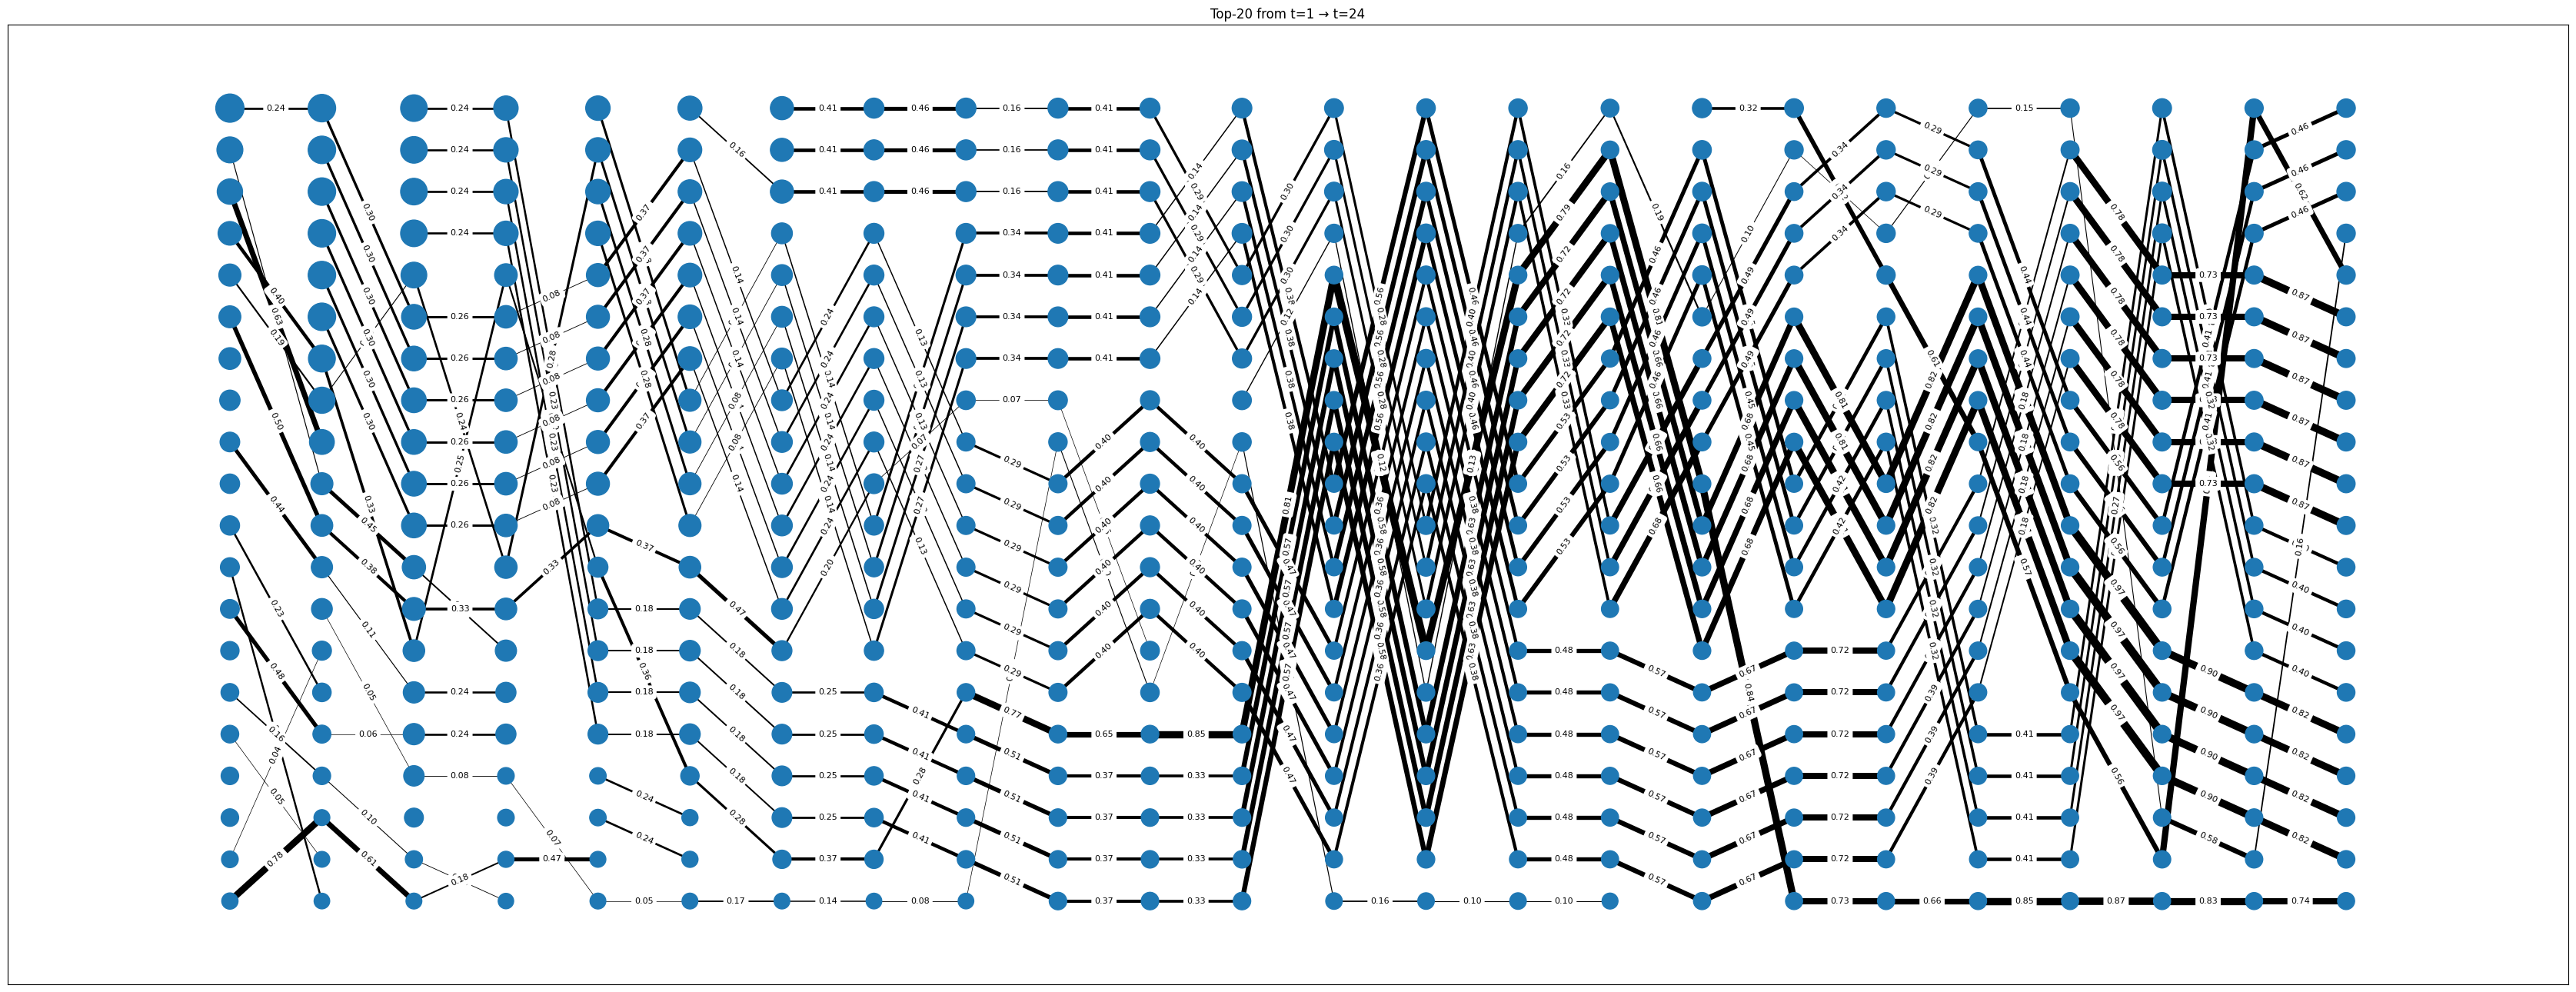

In [46]:
print(wjacc)
print(len(wjacc))
save_path = f"../output/{DISEASE}/leiden_tracking_results/leiden_tracking.png"
# save_path = None
_, edges = visualize_topk_from_edges(labels_dict, wjacc, 1,24,top_k = 20,score_cap = 0.03,save_path=save_path)

In [47]:
print(score_list)

[0.7651521149373784, 0.7846635346583908, 0.8104575580466021, 0.841518769685896, 0.875373063977178, 0.898865477577875, 0.9164200834536375, 0.9298452165614183, 0.9394630288603878, 0.9464846565498075, 0.9507444344396887, 0.9542085371261398, 0.9567034327492056, 0.9581632589007564, 0.9593903128644344, 0.9599810058622742, 0.9604223531813512, 0.9608348863697409, 0.961102583348061, 0.9613454421580222, 0.9616762151553138, 0.9618691264558906, 0.9622673883232509, 0.9622368167043327]


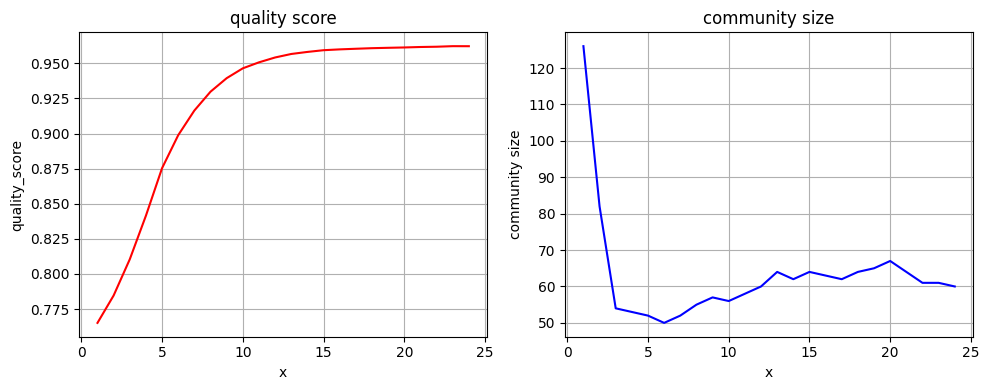

In [48]:
queue = [[i] for i in range(1,25)]
x = [T[0] for T in queue]
y1 = score_list
y2 = [len(communities_list[i]) for i in range(len(communities_list))]

# Create a figure with 2 subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left graph
axes[0].plot(x, y1, color='r')
axes[0].set_title("quality score")
axes[0].set_xlabel("x")
axes[0].set_ylabel("quality_score")
axes[0].grid(True)

# Right graph
axes[1].plot(x, y2, color='b')
axes[1].set_title("community size")
axes[1].set_xlabel("x")
axes[1].set_ylabel("community size")
axes[1].grid(True)

# Adjust spacing
plt.tight_layout()
plt.show()

In [57]:
mixed_time = 1 / (1-eigenvalues[1])
print(f"Mixed Time: {mixed_time}")

Mixed Time: 2.4916838950641917


In [31]:
# Final Average Clustering
average_t = [2,4,6,8,10,12]
num_neighbors = 100
resolution = 1.0

In [55]:
ddm_list = []
for i in average_t:
    ddm = np.load(f"../output/{DISEASE}/diffusion_dist_matrices/ddm_[{i}]_res-{resolution}.npy")
    ddm_list.append(ddm)

In [58]:
diffusion_dist_matrix = np.empty((num_genes,num_genes))
for ddm in ddm_list:
    np.add(diffusion_dist_matrix, 
           ddm, 
           out=diffusion_dist_matrix)
diffusion_dist_matrix = diffusion_dist_matrix / len(ddm_list)
np.save(f"../output/{DISEASE}/diffusion_dist_matrices/ddm_{average_t}_res-{resolution}.npy",diffusion_dist_matrix)

In [32]:
labels, score, communities, graph = DDBC(eigenvalues, eigenvectors, num_neighbors, resolution, average_t, leiden_method = method)
path = community_report_onepage(labels, score, out_pdf=pdf_path,
                                extra_text=[f"method={method}", f"resolution={resolution}"], 
                                bins=num_bins,time_steps = average_t)
print("Wrote:", path)

Wrote: ..\output\BIPOLAR\leiden_report.pdf


In [ ]:
print(communities)
DATA_DIRECTORY = OUTPUT_DIRECTORY + "leiden_results"
with open(f"{DATA_DIRECTORY}/result_communities.pkl", "wb") as f:
    pickle.dump(label_list, f)

[[4775, 4782, 4784, 4790, 4792, 4795, 4796, 4798, 4799, 4800, 4801, 4802, 4803, 4804, 4805, 4806, 4807, 4809, 4810, 4812, 4813, 4817, 4819, 4823, 4831, 4851, 4861, 4862, 4863, 4864, 4865, 4866, 4874, 4887, 4889, 4890, 4891, 4893, 4899, 4901, 4903, 4904, 4905, 4911, 4913, 4915, 4923, 4924, 4925, 4926, 4927, 4928, 4929, 4930, 4931, 4932, 4936, 4938, 4941, 4943, 4944, 4945, 4948, 4950, 4951, 4959, 4960, 4970, 4978, 4983, 4984, 4994, 4996, 4998, 4999, 5000, 5009, 5011, 5017, 5019, 5020, 5021, 5022, 5027, 5028, 5029, 5034, 5040, 5043, 5045, 5046, 5048, 5059, 5069, 5070, 5078, 5079, 5094, 5099, 5100, 5101, 5109, 5111, 5120, 5122, 5124, 5127, 5130, 5131, 5132, 5136, 5137, 5138, 5139, 5140, 5141, 5142, 5147, 5148, 5150, 5152, 5157, 5158, 5159, 5160, 5161, 5166, 5167, 5176, 5179, 5180, 5182, 5191, 5193, 5194, 5206, 5209, 5211, 5213, 5214, 5220, 5221, 5229, 5230, 5231, 5233, 5244, 5246, 5252, 5268, 5280, 5284, 5285, 5287, 5289, 5292, 5293, 5295, 5299, 5303, 5309, 5310, 5319, 5321, 5323, 5330, 53